## Train & Test one example hybrid forecast

This notebook contains code that trains and tests one example LSTM model, and then uses this model with the SEAS5 seasonal meteorological forecasts to create a hybrid forecast of seasonal streamflow volume.

Must run notebook Data_setup.ipynb first to save required input data in correct format.

This notebook is designed to run in Google colab. The required directories should be located in My Drive/Colab Notebooks/Hybrid_LSTM/. Input data from Data_setup.ipynb is saved in subdirectory Data/. Also require file indices_example.csv in subdirectory Output/.

Trained model is saved in subdirectory Models/, and output data saved in Output/.

Author: Taylor Swift-LaPointe

In [1]:
# import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from random import seed
import random
import csv
from scipy.stats import pearsonr

In [2]:
# import required tensorflow libraries for LSTM

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# get access to google drive
# all input data should be saved in Drive
# My Drive /
#    Colab Notebooks /
#         Hybrid_LSTM /
#               Data /
#               Models /
#               Output /

from google.colab import drive
drive.mount('/content/drive')
dir_data = '/content/drive/My Drive/Colab Notebooks/Hybrid_LSTM/Data'
dir_models = '/content/drive/My Drive/Colab Notebooks/Hybrid_LSTM/Models'
dir_output = '/content/drive/My Drive/Colab Notebooks/Hybrid_LSTM/Output'

Mounted at /content/drive


In [ ]:
### if running locally:

#dir_data = 'Data'
#dir_output = 'Output'
#dir_models = 'Models'

#### 1. Functions

Functions that will be called throughout notebook.

In [4]:
### function to calculate Nash-Sutcliffe Efficiency

def NSE_func(y_obs, y_model):
    numerator = 0
    denominator = 0
    y_obs_mean = np.mean(y_obs)
    for i in range(len(y_model)):
        num = (y_model[i] - y_obs[i])**2
        numerator += num
        denom = (y_obs[i] - y_obs_mean)**2
        denominator += denom
    nse = 1 - numerator/denominator
    return nse

In [5]:
### function to calculate Coefficient of Determination

def R2_func(y_obs, y_model):
    SS_res = 0
    SS_tot = 0
    y_obs_mean = np.mean(y_obs)
    for i in range(len(y_model)):
        SS_res += (y_obs[i] - y_model[i])**2
        SS_tot += (y_obs[i] - y_obs_mean)**2
    r_sq = 1 - SS_res/SS_tot
    return r_sq

In [6]:
### function to create model

def build_model(N_mons_prior, N_vars, learning_rate):
    # returns not-yet-trained LSTM model
    # inputs:
    #    N_mons_prior = number of prev. months used (=12)
    #    learning_rate = int
    # output:
    #    model = un-trained LSTM model

    model = Sequential()
    #model.add(InputLayer(input_shape = (N_mons_prior, N_vars)))
    model.add(InputLayer(shape = (N_mons_prior, N_vars)))
    model.add(LSTM(80, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

In [7]:
### function to save output after training LSTM

# each run tests on one year only, so 12 points
# store each ensemble member of each run in one file
def create_csv_output(run_id, dir_output, Ntestyrs):
    # create csv file to store all ensemble members of each run
    # fills first row with labels
    # inputs:
    #    dir_output = str of directory in DRIVE for output
    #    Ntestyrs = int
    #    run_id = int (run number)
    # outputs saved in dir_output

    ind_labels_array = np.empty(((Ntestyrs*12) + 1), dtype='U100')
    ind_labels_array[0] = 'ensemble'

    for i in range(Ntestyrs):
        ind_labels_array[1+(i*12):1+((i+1)*12)] = np.asarray(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='U100')
    index_filename = 'LSTM_output_run{}.csv'.format(run_id)
    with open(dir_output+'/'+index_filename, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(ind_labels_array)
        f.close()
    return

In [50]:
### function that loads pre-built model & trains 5 ensemble members

def train_models(run_id, dir_output, dir_models, x_train, y_train, x_val, y_val, x_test, y_test):
    # trains models
    # saves models to dir_models
    # saves test output of trained model on x_test to csv file in dir_output
    # inputs:
    #     run_id = str
    #     dir_output, dir_models = str, directories in DRIVE for output, models
    #     train/val/test data as tensors
    # outputs saved in dir_output, models saved in dir_models

    seeds = [00, 11, 22, 33, 44]  # 5 ensemble members
    learning_rate = 1e-4

    # create csv file to store output of all ensemble members
    #  placeholder so far -- will add to in below loop
    Ntestyrs = 1
    create_csv_output(run_id, dir_output, Ntestyrs)

    # loop through ensemble members
    for ii, s in enumerate(seeds):
        print('Training model ' + str(ii+1) + ' / ' + str(len(seeds)))

        # set random seeds
        seed(s)
        np.random.seed(s)
        tf.random.set_seed(s)

        # define earlier stopping callback to use in all models
        callbacks = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)

        # create train/val datasets for fine model
        batch_size = 64
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

        # generate & train fine model
        model = build_model(12, 3, learning_rate)
        model.fit(train_dataset, validation_data=val_dataset, epochs=200, verbose=0, callbacks=[callbacks])

        # predict test streamflow volume
        y_test_predict = model.predict(x_test, batch_size=batch_size, verbose=0)

        # save output to previously created csv file
        saveit_array = np.empty((len(y_test_predict)+1))
        saveit_array[0] = ii
        saveit_array[1:] = y_test_predict[:,0]

        filename = 'LSTM_output_run{}.csv'.format(run_id)
        with open(dir_output + '/' + filename, 'a') as f:
            writer = csv.writer(f)
            writer.writerow(saveit_array)
            f.close()

        # save model
        model_name = 'LSTM_model_run{}_{}.keras'.format(run_id, ii)
        model.save(dir_models + '/' + model_name)

    # end loop through ensemble members

    return

#### 2. Train and test one LSTM model

This code loads the input data saved in Data_setup.ipynb, separates it into training/validation/testing for one example test year, trains and validates LSTM model, saves trained model in Models/ and tests saved output data.

In [10]:
### load input & output data used to train the LSTM

## load data
# input data - Tmin, Tmax, Precip:
filename_input = 'Monthly_input_Mica_1981_2017_REGRID.csv'
data_input = pd.read_csv(dir_data + '/' + filename_input, header=0)
data_input = np.array(data_input)
# output data - volume:
filename_output = 'BPA_monthly_volumes_1981_2017.csv'
data_output = pd.read_csv(dir_data + '/' + filename_output, header=0)
data_output = np.array(data_output)

## check both start 01-1981
# input:
if data_input[0,0] == '01-1981':
    # cut out dates column
    dates_input = data_input[:,0]
    data_input_cut = data_input[:,1:]
else:
    # cut start to 01-1981
    start_ind = np.where(data_input[:,0] == '01-1981')[0][0]
    data_input_cut = data_input[start_ind:,1:]
    dates_input = data_input[start_ind:,0]
# output:
if data_output[0,0] == '01-1981':
    # cut out dates column
    dates_output = data_output[:,0]
    data_output_cut = data_output[:,1:]
else:
    start_ind = np.where(data_output[:,0] == '01-1981')[0][0]
    data_output_cut = data_output[start_ind:,1:]
    dates_output = data_output[start_ind:,0]

print('Input data: ', data_input_cut.shape)
print('Output data: ', data_output_cut.shape)

Input data:  (444, 3)
Output data:  (444, 1)


In [19]:
### get indices of train/val/test years
#  this selects which years are used for train/val/test and in what order

# !! Note: since previous 12-months of input data required for each train/val/test year,
#   first possible test year is 1982. Thus index 0 in this list is 1982, not 1981.

# number of training, validation, testing years
Ntrainyrs = 28
Nvalyrs = 7
Ntestyrs = 1  # for leave-one-year-out validation method

## load saved indices from csv file (choose which test year)
# to test on 2014:
run_indices = pd.read_csv(dir_output + '/indices_example1.csv', header=0)
# to test on 1982:
#run_indices = pd.read_csv(dir_output + '/indices_example.csv', header=0)
run_indices = np.array(run_indices)[0]

## select train/val/test indices
train_inds = run_indices[1:Ntrainyrs+1]
val_inds = run_indices[Ntrainyrs+1:Ntrainyrs+Nvalyrs+1]
test_ind = run_indices[-1]

## print test year to check
test_years_all = np.arange(1982,2018)
test_year = test_years_all[test_ind]
print('Test year = ', test_year)

Test year =  2014


In [21]:
### normalize input & output data relative to training years

# placeholder arrays for training data
data_input_train = np.zeros((Ntrainyrs*12,3))
data_output_train = np.zeros((Ntrainyrs*12,))
dates_input_train = np.zeros((Ntrainyrs*12,), dtype='U100')

# collect data from training years
# loop through training years
for i in range(Ntrainyrs):
    # index 0=1982, but data starts at 1981
    #  so add 1 to trainyr_ind
    trainyr_ind = train_inds[i]+1
    data_input_train[i*12:(i+1)*12,:] = data_input_cut[trainyr_ind*12:(trainyr_ind+1)*12,:]
    data_output_train[i*12:(i+1)*12] = data_output_cut[trainyr_ind*12:(trainyr_ind+1)*12,0]
    dates_input_train[i*12:(i+1)*12] = dates_input[trainyr_ind*12:(trainyr_ind+1)*12]
# end loop through training years

# take mean, stdev of each variable over training period
data_input_train_mean = np.mean(data_input_train, axis=0)
data_input_train_std = np.std(data_input_train, axis=0)
data_output_train_mean = np.mean(data_output_train)
data_output_train_std = np.std(data_output_train)

# normalize all data w.r.t training period
data_input_norm = np.empty_like(data_input_cut)
# loop through input variables
for n in range(3):
    data_input_norm[:,n] = (data_input_cut[:,n] - data_input_train_mean[n])/data_input_train_std[n]
# end loop through variables
data_output_norm = np.empty_like(data_output_cut)
data_output_norm = (data_output_cut - data_output_train_mean)/data_output_train_std

In [35]:
### create LSTM input and output format

# input shape: (N_observations, N_months_prior, N_vars)
# output shape: (N_observations,)

# select number of months before present to use for prediction
N_mons_prior = 12

# number of variables
N_vars = 3

# length of data to be used
N_observations = len(data_output_norm) - N_mons_prior

# placeholders for input, output data
x_input = np.zeros((N_observations, N_mons_prior, N_vars))
y_output = np.zeros((N_observations,))
y_dates = np.zeros((N_observations,), dtype='U100') # to keep track of dates of output

# for each "observation", input is previous 12 months of temp/precip,
#                         output is streamflow volume of next month
# Note: both data_input and data_output start 01/1981
#   after this step, x_input will start 01/1981, y_output will start 01/1982
for i in range(N_observations):
    x_input[i,:,:] = data_input_norm[i:i+N_mons_prior,:]
    y_output[i] = data_output_norm[i+N_mons_prior,0]
    y_dates[i] = dates_output[i+N_mons_prior]

print('LSTM input shape: ', x_input.shape)
print('LSTM output shape: ', y_output.shape)
print(' start, end dates: ', y_dates[0], y_dates[-1])

LSTM input shape:  (432, 12, 3)
LSTM output shape:  (432,)
 start, end dates:  01-1982 12-2017


In [45]:
### separate out train/val/test data

# placeholders for train/val/test data
x_train = np.zeros((Ntrainyrs*12, N_mons_prior, N_vars))
x_val = np.zeros((Nvalyrs*12, N_mons_prior, N_vars))
x_test = np.zeros((Ntestyrs*12, N_mons_prior, N_vars))
y_train = np.zeros((Ntrainyrs*12,))
y_val = np.zeros((Nvalyrs*12,))
y_test = np.zeros((Ntestyrs*12,))

## add data
# loop through training years
for i in range(Ntrainyrs):
    trainyr_ind = train_inds[i]
    x_train[i*12:(i+1)*12,:,:] = x_input[trainyr_ind*12:(trainyr_ind+1)*12,:,:]
    y_train[i*12:(i+1)*12] = y_output[trainyr_ind*12:(trainyr_ind+1)*12]
# end loop through training years

# loop through validation years
for i in range(Nvalyrs):
    valyr_ind = val_inds[i]
    x_val[i*12:(i+1)*12,:,:] = x_input[valyr_ind*12:(valyr_ind+1)*12,:,:]
    y_val[i*12:(i+1)*12] = y_output[valyr_ind*12:(valyr_ind+1)*12]
# end loop through validation years

# add test year data (one year only)
testyr_ind = test_ind
x_test[0:12,:,:] = x_input[testyr_ind*12:(testyr_ind+1)*12,:,:]
y_test[0:12] = y_output[testyr_ind*12:(testyr_ind+1)*12]

## convert train/val/test arrays to tensors
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

print('x_train shape: ', x_train.shape)
print('x_val shape: ', x_val.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (336, 12, 3)
x_val shape:  (84, 12, 3)
x_test shape:  (12, 12, 3)


In [51]:
### train LSTM model

# one LSTM model has 5 ensemble members
# all are trained/validated on above-defined train/val data
# and trained models are tested on above-defined test data
# trained ensemble models saved in dir_models
# tested output saved in dir_output

#run_id = 0  # if running multiple models, change this
run_id = 32

train_models(run_id, dir_output, dir_models, x_train, y_train, x_val, y_val, x_test, y_test)

Training model 1 / 5
Training model 2 / 5
Training model 3 / 5
Training model 4 / 5
Training model 5 / 5


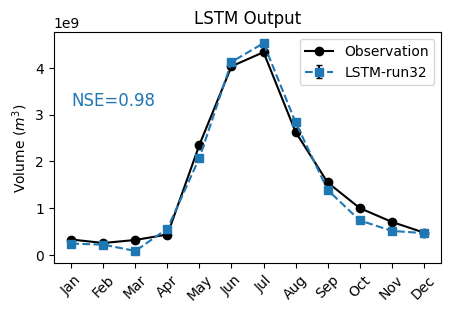

In [57]:
### load saved test output

filename_output = 'LSTM_output_run{}.csv'.format(run_id)
data_output = pd.read_csv(dir_output + '/' + filename_output, header=0)
data_output = np.array(data_output)

# de-normalize data
y_test_unnorm = y_test*data_output_train_std + data_output_train_mean # observation
data_output_unnorm = data_output[:,1:]*data_output_train_std + data_output_train_mean # model prediction

# calculate ensemble mean, stdev
data_output_mean = np.mean(data_output_unnorm, axis=0)
data_output_std = np.std(data_output_unnorm, axis=0)

# calculate NSE of ensemble average
NSE = NSE_func(np.asarray(y_test_unnorm), data_output_mean)

# plot ensemble average
fig = plt.figure(figsize=(5,3))
plt.plot(np.arange(0,12,1), y_test_unnorm, 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), data_output_mean, yerr=data_output_std, fmt='s--', ecolor='k', capsize=2, label='LSTM-run{}'.format(run_id))
plt.text(0,3.2e9,'NSE={}'.format(round(NSE,2)),fontsize=12, color='tab:blue')
tick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0,12,1), tick_labels, rotation=45)
plt.ylabel(r'Volume ($m^3$)')
plt.title('LSTM Output')
plt.legend()
plt.show()

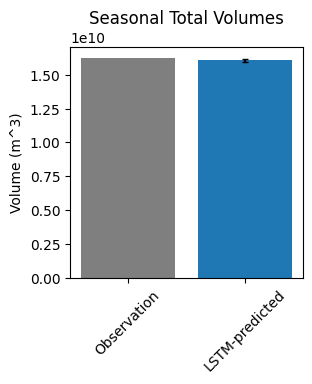

In [58]:
### calculate seasonal total volumes

# volume of observed data
y_test_volume = np.sum(y_test_unnorm[0:9])
# volume of all 5 ensemble members
data_output_volume = np.sum(data_output_unnorm[:,0:9], axis=1)
# volume of ensemble average
data_output_mean_volume = np.sum(data_output_mean[0:9])

# plot as bar graph
fig = plt.figure(figsize=(3,3))
plt.bar(0, y_test_volume, color='tab:gray')
plt.bar(1, data_output_mean_volume, yerr=np.std(data_output_volume), color='tab:blue', ecolor='k', capsize=2)
plt.xticks([0,1], ['Observation', 'LSTM-predicted'], rotation=45)
plt.ylabel(r'Volume (m^3)')
plt.title('Seasonal Total Volumes')
plt.show()

#### 3. Create hybrid forecast of seasonal volume

This code loads the ECMWF SEAS5 seasonal meteorological hindcasts data saved in Data_setup.ipynb, uses it as input into the saved LSTM model created in previous section, to create hybrid forecast of seasonal volume for test year.

Note: must run all code in Section 2 first, as this code uses saved variables.

In [61]:
### load SEAS5 hindcast data and ERA5 climatology data

# SEAS5 hindcasts
filename_SEAS5 = 'SEAS5_monthly_input_Mica_1981_2017.csv'
data_input_SEAS5 = pd.read_csv(dir_data + '/' + filename_SEAS5, header=0)
data_input_SEAS5 = np.array(data_input_SEAS5)
data_dates_SEAS5 = data_input_SEAS5[:,0]

# Clim
filename_clim = 'Monthly_climatology_Mica_1981_2017_REGRID.csv'
data_input_clim = pd.read_csv(dir_data + '/' + filename_clim, header=0)
data_input_clim = np.array(data_input_clim)

## normalize SEAS5 & Clim relative to training data
data_input_clim_norm = np.empty_like(data_input_clim[:,1:])
data_input_SEAS5_norm = np.empty_like(data_input_SEAS5[:,1:])
# loop through variables
for i in range(3):
    data_input_clim_norm[:,i] = (data_input_clim[:,i+1] - data_input_train_mean[i])/data_input_train_std[i]
    data_input_SEAS5_norm[:,i] = (data_input_SEAS5[:,i+1] - data_input_train_mean[i])/data_input_train_std[i]

print(data_input_clim_norm.shape)
print(data_input_SEAS5_norm.shape)

(12, 3)
(222, 3)


In [63]:
### turn SEAS5 & Clim into required LSTM input format
# first 6 months have only SEAS5 data in forecast year
# after this, has 6 months of SEAS5 data + i months of climatology in forecast year

# placeholders
x_test_wSEAS5 = np.zeros((12, 12, 3))
x_test_dates_wSEAS5 = np.zeros((12, 12), dtype='U100') # for dates to check

# find index to start from, based on test year
# ERA5 input needs to start 12 months before test year
start_ind = np.where(dates_input == "01-{}".format(test_year))[0][0]-12  # =testyear-1yr
# SEAS5 input needs to start on test year
start_ind_SEAS5 = np.where(data_dates_SEAS5 == '01-{}'.format(test_year))[0][0]  # =testyear

## add data to placeholder
# first 6 months (i in range 0-6)
#   = i months of ERA5 + (12-i) months of SEAS5
for i in range(0,7,1):
    x_test_wSEAS5[i,0:(12-i),:] = data_input_norm[start_ind+i:start_ind+12,:]  # add prev 1yr
    x_test_wSEAS5[i,(12-i):12,:] = data_input_SEAS5_norm[start_ind_SEAS5:start_ind_SEAS5+i,:]
    x_test_dates_wSEAS5[i,0:(12-i)] = dates_input[start_ind+i:start_ind+12]
    x_test_dates_wSEAS5[i,(12-i):12] = data_dates_SEAS5[start_ind_SEAS5:start_ind_SEAS5+i]

# next 6 months (i in range 7-12)
#   = i months of ERA5 + 6 months of SEAS5 + (6-i) months of Clim
for i in range(7,12,1):
    x_test_wSEAS5[i,0:(12-i),:] = data_input_norm[start_ind+i:start_ind+12,:]  # add prev 1yr
    x_test_wSEAS5[i,(12-i):(12-i+6),:] = data_input_SEAS5_norm[start_ind_SEAS5:start_ind_SEAS5+6,:]  # add SEAS5 Jan-Jun
    x_test_wSEAS5[i,(12-i+6):12,:] = data_input_clim_norm[6:i,:] # add clim Jul-Sep/Dec
    x_test_dates_wSEAS5[i,0:(12-i)] = dates_input[start_ind+i:start_ind+12]
    x_test_dates_wSEAS5[i,(12-i):(12-i+6)] = data_dates_SEAS5[start_ind_SEAS5:start_ind_SEAS5+6]
    x_test_dates_wSEAS5[i,(12-i+6):12] = np.arange(7,i+1,1)

In [70]:
### load saved LSTM models
# these models were trained in Section 2 above

batch_size = 64

model0 = tf.keras.models.load_model(dir_models + '/LSTM_model_run{}_0.keras'.format(run_id))
model1 = tf.keras.models.load_model(dir_models + '/LSTM_model_run{}_1.keras'.format(run_id))
model2 = tf.keras.models.load_model(dir_models + '/LSTM_model_run{}_2.keras'.format(run_id))
model3 = tf.keras.models.load_model(dir_models + '/LSTM_model_run{}_3.keras'.format(run_id))
model4 = tf.keras.models.load_model(dir_models + '/LSTM_model_run{}_4.keras'.format(run_id))

In [81]:
### use SEAS5 input into loaded LSTM models

# placeholder for output
y_test_predict_wSEAS5_all = np.zeros((6, 12))

# predict with new input
y_test_predict_wSEAS5_all[0,:] = np.asarray(model0.predict(tf.convert_to_tensor(x_test_wSEAS5), batch_size=batch_size, verbose=0)[:,0])
y_test_predict_wSEAS5_all[1,:] = np.asarray(model1.predict(tf.convert_to_tensor(x_test_wSEAS5), batch_size=batch_size, verbose=0)[:,0])
y_test_predict_wSEAS5_all[2,:] = np.asarray(model2.predict(tf.convert_to_tensor(x_test_wSEAS5), batch_size=batch_size, verbose=0)[:,0])
y_test_predict_wSEAS5_all[3,:] = np.asarray(model3.predict(tf.convert_to_tensor(x_test_wSEAS5), batch_size=batch_size, verbose=0)[:,0])
y_test_predict_wSEAS5_all[4,:] = np.asarray(model4.predict(tf.convert_to_tensor(x_test_wSEAS5), batch_size=batch_size, verbose=0)[:,0])

### add ensemble average
y_test_predict_wSEAS5_all[5,:] = np.mean(y_test_predict_wSEAS5_all[0:5,:], axis=0)

### de-normalize all ensembles
y_test_predict_wSEAS5_unnorm_all = y_test_predict_wSEAS5_all*data_output_train_std + data_output_train_mean

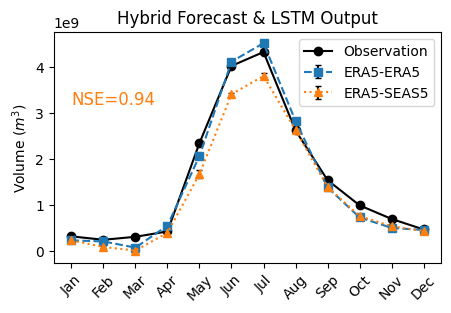

In [88]:
### plot ensemble average
# plot with LSTM model with ERA5 input

NSE_hybrid = NSE_func(np.asarray(y_test_unnorm), y_test_predict_wSEAS5_unnorm_all[5,:])

fig = plt.figure(figsize=(5,3))
plt.plot(np.arange(0,12,1), y_test_unnorm, 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), data_output_mean, yerr=data_output_std, fmt='s--', color='tab:blue', ecolor='k', capsize=2,
             label='ERA5-ERA5')
plt.errorbar(np.arange(0,12,1), y_test_predict_wSEAS5_unnorm_all[5,:], yerr=np.std(y_test_predict_wSEAS5_unnorm_all[0:5,:],axis=0),
             fmt='^:', color='tab:orange', ecolor='k', capsize=2, label='ERA5-SEAS5')
plt.text(0, 3.2e9,'NSE={}'.format(round(NSE_hybrid,2)), fontsize=12, color='tab:orange')
tick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0,12,1), tick_labels, rotation=45)
plt.ylabel(r'Volume ($m^3$)')
plt.title('Hybrid Forecast & LSTM Output')
plt.legend()
plt.show()

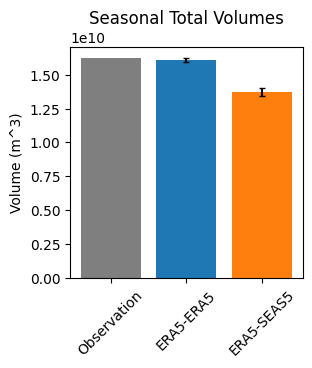

In [73]:
### calculate seasonal total volumes

# volume of all 5 ensemble members & ensemble mean
y_test_predict_wSEAS5_volume = np.sum(y_test_predict_wSEAS5_unnorm_all[:,0:9], axis=1)

# plot as bar graph
fig = plt.figure(figsize=(3,3))
plt.bar(0, y_test_volume, color='tab:gray')
plt.bar(1, data_output_mean_volume, yerr=np.std(data_output_volume), color='tab:blue', ecolor='k', capsize=2)
plt.bar(2, y_test_predict_wSEAS5_volume[5], yerr=np.std(y_test_predict_wSEAS5_volume[0:5]), color='tab:orange',
        ecolor='k', capsize=2)
plt.xticks([0,1,2], ['Observation', 'ERA5-ERA5', 'ERA5-SEAS5'], rotation=45)
plt.ylabel(r'Volume (m^3)')
plt.title('Seasonal Total Volumes')
plt.show()